In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [6]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [7]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [8]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
# x ==> (200, 5)
# x_one_hot ==> (200, 5, 2)
rnn_inputs = tf.unstack(x_one_hot, axis=1)
# run_inputs ==> (200, 2)

### 解释unstack的意思
这里使用unstack是为了把一个batch的200句话平行输入RNN.

步骤如下:
1. 首先把batch_size定义为200, 

### tf.unstack(value, axis=0)
what is the meaning of axis?
1. function: unstack the tensor from rank R to rank (R-1)
    - in the example above, the rank R of x_one_hot is 3, rnn_inputs'rank is 2.
    - the axis is used for value.shape[axis]
2. why do it use unstack to deminish the data?
    - from the document we can know that there should be 5 tensors in run_inputs. But the shape is only (200, 2), why?
    - refer to the np.unstack()
    - There should be 5 (200, 2) matrixs.

In [9]:
num_classes

2

In [10]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

这个操作实现的就是下面这个运算
$(x @ s) \times w + b$

### tf.concat & tf.stack
1. 共同点: 这两个函数都是用来reshape tensor的.
2. 不同点:
    - concat 把拥有一个共同维度的数组按照该维度组合.
    - stack 可以把一个大于2维的数组按照一个指定维度来展开.
3. 两者之间的转换如何举例?

In [11]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = [] # A list of states based on the input size.
for rnn_input in rnn_inputs: # run_inputs ==> (200, 2) * 5 list
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state) 
final_state = rnn_outputs[-1]

这个state 是一个自己定义维度的一个向量, 对于每一个batch 都有 *一系列* 的states和它对应.
$$state \in R^{batch\_size \times num\_steps}$$
### TODO: state向量的维度是多少比较合适呢?


In [12]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax', reuse=None):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], 
                        initializer=tf.constant_initializer(0.0))

In [13]:
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
# logits ==> (time_step, batch_size, num_classes)
predictions = [tf.nn.softmax(logit) for logit in logits]
# predictions ==> logits.shape
# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)
# y_as_list ==> 5 * (200, 2)
#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

### TODO: what is the difference between the two w and b? Are they the same, or they are different?


The above is calculating the states with the next input, and store into a list named _prediction_ .
$$state \times w + b $$

- the size of each variables.
$$ w\in R^{d \times (n+s)}$$


### 关于 tf.variable_scope(name) 
scope的作用类似于一个命名管理器.

不同scope下面的变量可以使用相同的名字.

In [14]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.631549962163
Average loss at step 200 for last 250 steps: 0.529166456461
Average loss at step 300 for last 250 steps: 0.520547061563
Average loss at step 400 for last 250 steps: 0.51986587435

EPOCH 1
Average loss at step 100 for last 250 steps: 0.522457573414
Average loss at step 200 for last 250 steps: 0.51359729588
Average loss at step 300 for last 250 steps: 0.513097512722
Average loss at step 400 for last 250 steps: 0.513096005023

EPOCH 2
Average loss at step 100 for last 250 steps: 0.517191099823
Average loss at step 200 for last 250 steps: 0.51189797014
Average loss at step 300 for last 250 steps: 0.510683863163
Average loss at step 400 for last 250 steps: 0.510342955589

EPOCH 3
Average loss at step 100 for last 250 steps: 0.517033561468
Average loss at step 200 for last 250 steps: 0.511458417177
Average loss at step 300 for last 250 steps: 0.509486623704
Average loss at step 400 for last 250 steps: 0.509473537505

EPOCH 

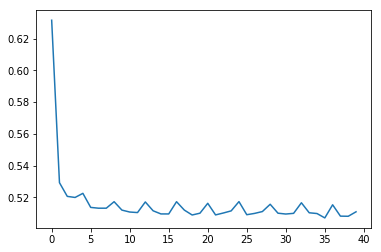

In [16]:
training_losses = train_network(num_steps=10, state_size=4, num_epochs=10)
plt.plot(training_losses)

The author said this is the first dependency.
But why?